In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(linewidth=150)

In [15]:
class rb():
    position = 10
    def __init__(self, position):
        self.position = position
    def apply(self, systemmatrix, rhs, delta_x):
        pass
class neumann(rb):
    waermestrom = 5
    def __init__(self, position, waermestrom):
        super(neumann,self).__init__(position)
        self.waermestrom = waermestrom
    def apply(self, systemmatrix, rhs, delta_x):
        if (self.position == 0):
            # Vorwärtsdifferenz
            systemmatrix[self.position, 0:2] = (1, -1)
        elif (self.position < len(rhs)):
            # Rückwärtsdifferenz
            systemmatrix[self.position, self.position-1:self.position+1] = (-1, 1)
        else:
            raise ValueError("Out of bounds")
        rhs[self.position] = rhs[self.position] + self.waermestrom * delta_x
class dirichlet(rb):
    temperatur = 5
    def __init__(self, position, temperatur):
        super(dirichlet,self).__init__(position)
        self.temperatur = temperatur
    def apply(self, systemmatrix, rhs, delta_x):
        if (self.position > len(rhs)):
            raise ValueError("Out of bounds")
        systemmatrix[self.position, self.position] = 1
        rhs[self.position] = rhs[self.position] + self.temperatur

In [16]:
def assemble(knoten, l, rben):
    delta_x = l / (knoten-1)
    systemmatrix = np.zeros((knoten, knoten))
    rhs = np.zeros((knoten))
    for i in range(1, knoten-1):
        systemmatrix[i, i-1:i+2] = (-1, 2, -1)
    for rb in rben:
        rb.apply(systemmatrix, rhs, delta_x)        
    return systemmatrix, rhs
def solve(knoten, l, rben):
    systemmatrix, rhs = assemble(knoten, l, rben)
    solution = np.linalg.solve(systemmatrix, rhs)
    return np.linspace(0, l, knoten), solution, systemmatrix, rhs

### Aufgabe 2.3.1
_2x Neumann_

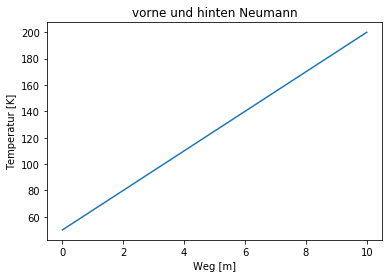

In [5]:
knoten = 10
rb_vorne = dirichlet(0, 50)
rb_hinten = dirichlet(knoten-1, 200)
l = 10
x, T1, s, r = solve(knoten, l, [rb_vorne, rb_hinten])
plt.plot(x, T1)
plt.title("vorne und hinten Neumann")
plt.xlabel("Weg [m]")
plt.ylabel("Temperatur [K]")
plt.show()

_Neumann und Dirichlet_

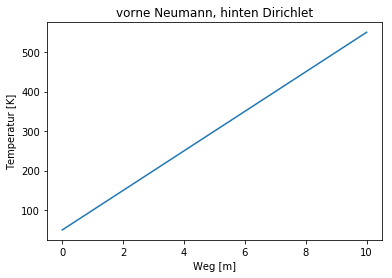

In [6]:
knoten = 10
rb_vorne = dirichlet(0, 50)
rb_hinten = neumann(knoten-1, 50)
l = 10
x, T2, s, r = solve(knoten, l, [rb_vorne, rb_hinten])
plt.plot(x, T2)
plt.title("vorne Neumann, hinten Dirichlet")
plt.xlabel("Weg [m]")
plt.ylabel("Temperatur [K]")
plt.show()

### Aufgabe 2.3.2
Analytisch: es gibt keine "absolute" Randbedingung, die Lösung kann beliebig nach oben und unten verschoben werden.
Numerisch: Die Matrix hat nicht mehr vollen Rang, ein Eigenwert verschwindet.

In [7]:
knoten = 3
rb_vorne = neumann(0, 50)
rb_hinten = neumann(knoten-1, 50)
l = 10
s, r = assemble(knoten, l, [rb_vorne, rb_hinten])
print(s)
print("Eigenwerte:")
print(np.linalg.eig(s)[0])

[[ 1. -1.  0.]
 [-1.  2. -1.]
 [ 0. -1.  1.]]
Eigenwerte:
[ 3.00000000e+00  1.00000000e+00 -3.36770206e-17]


### Aufgabe 2.3.3
Analytische Lösungen

Für $0 = \kappa \dfrac{\partial^2 T}{\partial x^2}$ ist die allgemeine Lösung $T = c_1 \cdot x + c_2$. 

Für zwei Neumann-RBen folgt: 
$T_1 = T(x = 0) = c_2$, $T_2 = T(x=L) = c_1 \cdot L + c_2 = c_1 \cdot L + T_1 \rightarrow c_1 = \dfrac{T_2 - T_1}{L}$

und damit die analytische Lösung für die gegebenen Werte: $T(x) = 15 \frac{K}{m} \cdot x + 50 K$

Für Neumann vorne und Dirichlet hinten:
$T_1 = T(x = 0) = c_2$, $ \left.\frac{d T}{d x}\right|_L = c_1$

und damit für die gegebenen Werte: $T(x) = 50 \frac{K}{m} + 50 K$



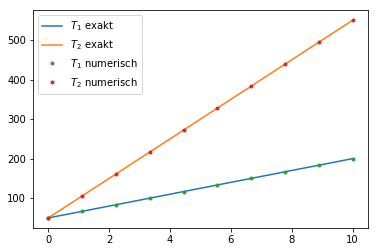

In [8]:
exakt_1 = [15 * xi + 50 for xi in x]
exakt_2 = [50 * xi + 50 for xi in x]
plt.plot(x, exakt_1, label="$T_1$ exakt")
plt.plot(x, exakt_2, label="$T_2$ exakt")
plt.plot(x, T1, ".", label="$T_1$ numerisch")
plt.plot(x, T2, ".", label="$T_2$ numerisch")
plt.legend()

_Netzstudie_

Für 6 und 11 Punkte liegt die numerische Lösung exakt auf der analytischen Lösung.

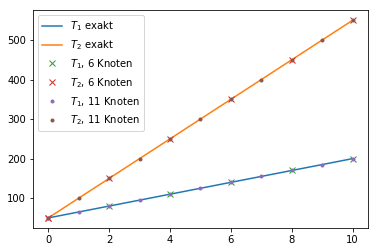

In [9]:
result = {}
x = np.linspace(0,10,10)
plt.plot(x, exakt_1, label="$T_1$ exakt")
plt.plot(x, exakt_2, label="$T_2$ exakt")
for knoten in [6, 11]:
    rb_vorne = dirichlet(0, 50)
    rb_hinten2 = neumann(knoten-1, 50)
    rb_hinten1 = dirichlet(knoten-1, 200)
    x, T1, s, r = solve(knoten, 10, [rb_vorne, rb_hinten1])
    x, T2, s, r = solve(knoten, 10, [rb_vorne, rb_hinten2])
    plt.plot(x, T1, "." if knoten == 11 else "x", label="$T_1$, {} Knoten".format(knoten))
    plt.plot(x, T2, "." if knoten == 11 else "x", label="$T_2$, {} Knoten".format(knoten))
    result[knoten] = [T1, T2]
plt.legend()
plt.show()

### Aufgabe 2.3.4 / 2.3.5

Das ist erst interessant, sobald wir Wärmequellen vorgeben, da erst dann die Lösung nicht mehr linear ist.

Wir wählen folgende Funktion für die Wärmequellen (mit $s_0 = 200 \frac{K}{s}$):
$$s(x) = \begin{cases} 0 & x < \frac{L}{5} \\ s_0 & \frac{L}{5} \leq x < \frac{2L}{5} \\ 0 & \mathrm{sonst}\end{cases}$$
Das liefert die folgende analytische Lösung:
$$T(x) = - \frac 12 \frac{s(x)}{\kappa} + c_1 \cdot x + c_2 \rightarrow T(x) = \begin{cases} c_1 x + c_2 & x < \frac{L}{5} \\ -\frac{s_0}{2\kappa}x^2 + c_3 x + c_4 & \frac{L}{5} \leq x < \frac{2L}{5} \\ c_5 x + c_6 & \mathrm{sonst}\end{cases}$$
Als Randbedingungen wählen wir eine Dirichlet-RB bei $x=0$: $T = 300K = c_2$ und eine Neumann-RB bei $x=L$: adiabater Rand, d.h. $\left.\frac{dT}{dx}\right|_L = 0 \rightarrow c_5 = 0$. Außerdem ist der Temperaturverlauf stetig und sprungfrei.
Das liefert: \begin{equation}c_1 \cdot \frac{L}{5} + c_2 = -\frac{s_0}{2\kappa} \frac{L^2}{25} + c_3 \frac{L}{5} + c_4\end{equation} 
$$c_1 = -\frac{s_0}{\kappa} \frac{L}{5} + c_3$$
$$-\frac{s_0}{2\kappa} \frac{4L^2}{25} + c_3 \frac{2L}{5} + c_4 = c_6$$
$$-\frac{s_0}{\kappa} \frac{2L}{5} + c_3 = 0 \rightarrow c_3 = \frac{s_0}{\kappa} \frac{2L}{5} = 80 \frac{K}{m}$$
Einsetzen in Gl. 2
$$c_1 = -\frac{s_0}{\kappa} \frac{L}{5} + \frac{s_0}{\kappa} \frac{2L}{5} = \frac{s_0}{\kappa} \frac{L}{5} = 40 \frac{K}{m}$$
Beides in Gl. 1:
$$\frac{s_0}{\kappa} \frac{L^2}{25} + c_2 = -\frac{s_0}{2\kappa} \frac{L^2}{25} + \frac{s_0}{\kappa} \frac{2L^2}{25} + c_4 \rightarrow c_2 - \frac{s_0}{\kappa} \frac{L^2}{50} = c_4 = 260 K$$

$$-\frac{s_0}{\kappa} \frac{4L^2}{50} + \frac{s_0}{\kappa} \frac{4L}{25} +c_2 - \frac{s_0}{\kappa} \frac{L^2}{50} = c_6 \rightarrow c_6 = c_2 + \frac{s_0}{\kappa}\frac{3L^2}{50} = 420 K$$


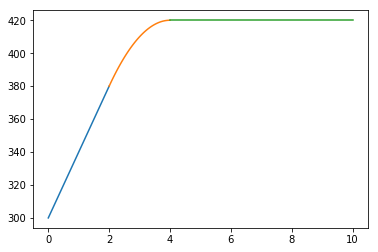

In [10]:
x1 = np.linspace(0, 2, 100)
x2 = np.linspace(2,4,100)
x3 = np.linspace(4,10,100)
y1 = [40 * xv + 300 for xv in x1]
y2 = [-200/20 * xv**2 + 80 * xv + 260 for xv in x2]
y3 = [420 for xv in x3]
xan = np.concatenate([x1, x2, x3])
yan = np.concatenate([y1, y2, y3])
plt.plot(x1, y1, x2, y2, x3, y3)
plt.show()

In [11]:
class waermequelle(rb):
    staerke = 5
    kappa = 10
    def __init__(self, position, staerke):
        super(waermequelle,self).__init__(position)
        self.staerke = staerke
    def apply(self, systemmatrix, rhs, delta_x):
        rhs[self.position] = rhs[self.position] + self.staerke * delta_x**2 / self.kappa

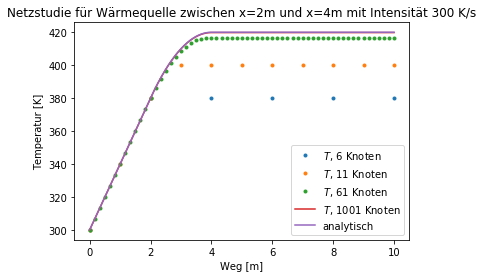

In [12]:
result = {}
knoten = 1001
for knoten in [6, 11, 21, 41, 61, 101, 201, 501, 1001]:
    wq_start = int((knoten-1)/10*2)
    wq_ende = int((knoten-1)/10*4)
    rb_vorne = dirichlet(0, 300)
    rb_hinten = neumann(knoten-1, 0)
    wqs = [waermequelle(i, 200) for i in range(wq_start, wq_ende)]
    l = 10
    x, T, s, r = solve(knoten, l, [rb_vorne, rb_hinten] + wqs)
    if (knoten == 6 or knoten == 11 or knoten== 61 or knoten == 1001):
        plt.plot(x, T, "." if knoten != 1001 else "-", label="$T$, {} Knoten".format(knoten))
    result[knoten] = [x, T]

plt.title("Netzstudie für Wärmequelle zwischen x=2m und x=4m mit Intensität 300 K/s")
plt.xlabel("Weg [m]")
plt.ylabel("Temperatur [K]")

plt.plot(xan, yan, label="analytisch")
plt.legend()
plt.show()


In [13]:
errordict = {}
for key, values in result.items():
    errors = []
    for value in zip(values[0], values[1]):
        position_in_exact = (np.abs(xan-value[0])).argmin()
        exact = yan[position_in_exact]
        numeric = value[1]
        error = exact - numeric
        errors += [error]
    errordict[key] = [values[0], errors]

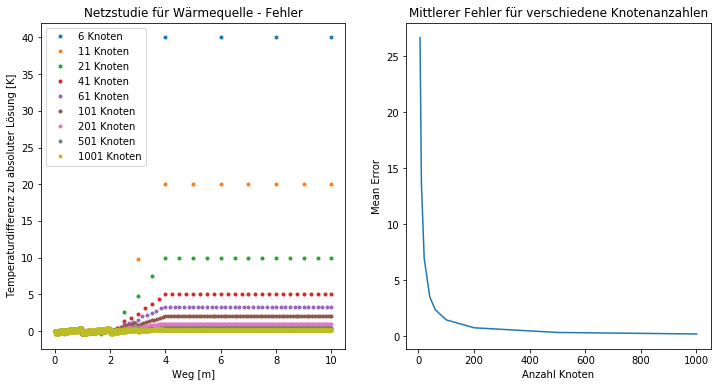

In [14]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

meanerrors = {}
for key, values in errordict.items():
    meanerrors[key] = sum(np.abs(values[1]))/key
    plt.plot(values[0], values[1], ".", label="{} Knoten".format(key))
plt.title("Netzstudie für Wärmequelle - Fehler")
plt.xlabel("Weg [m]")
plt.ylabel("Temperaturdifferenz zu absoluter Lösung [K]")
plt.legend()
ax = plt.subplot(1, 2, 2)
plt.xlabel("Anzahl Knoten")
plt.ylabel("Mean Error")
plt.title("Mittlerer Fehler für verschiedene Knotenanzahlen")
plt.plot(meanerrors.keys(), list(meanerrors.values()))
plt.show()

Es ist gut erkennbar, dass dies ein Verfahren zweiter Ordnung ist.